Решить задачу регрессии.
Получить максимальную метрику качества (R2, RMSE).

Введение
Целью данной задачи является прогнозирование суммы пятничных распродаж в магазинах сети Walmart с помощью построения регрессионных моделей и их анализа.
Набор данных состоит из исторических данных, которые охватывают продажи с 2010-02-05 по 2012-11-01, предствленных в файле Walmart.csv

1. #Использовать приплайны.
2. #Выполнить поиск лучших параметров / *hyperopt / **optuna
3. #Кроссвалидация / различные типы проверок.
4. #Сохранить и загрузить моделль. 
5. #H20 (если получиться)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor 
from sklearn.model_selection import train_test_split, cross_val_score
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.metrics import mean_squared_error, r2_score
import phik
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import RidgeCV, SGDRegressor

In [4]:
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [3]:
# Загрузка датасета
data = pd.read_csv('Walmart.csv')

Посмотрим на структуру данных

In [7]:
data.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [7]:
data.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


In [8]:
data.dtypes

Store             int64
Date             object
Weekly_Sales    float64
Holiday_Flag      int64
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
dtype: object

In [3]:
missing_counts = data.isna().sum()
missing_counts

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

In [ ]:
Пропусков в данных нет

In [4]:
data['Date'] = pd.to_datetime(data['Date'], dayfirst=1)

Вместо даты определим времена года, которые могут вляить на целевую переменную

In [5]:
# Определяем времена года
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    elif month in [9, 10, 11]:
        return 'autumn'

# Применяем функцию к колонке с датой
data['season'] = data['Date'].apply(get_season)

# Создаем бинарные колонки для каждого времени года
data = pd.get_dummies(data, columns=['season'], prefix='', prefix_sep='')

data.drop('Date', axis=1)

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,autumn,spring,summer,winter
0,1,1643690.90,0,42.31,2.572,211.096358,8.106,False,False,False,True
1,1,1641957.44,1,38.51,2.548,211.242170,8.106,False,False,False,True
2,1,1611968.17,0,39.93,2.514,211.289143,8.106,False,False,False,True
3,1,1409727.59,0,46.63,2.561,211.319643,8.106,False,False,False,True
4,1,1554806.68,0,46.50,2.625,211.350143,8.106,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...
6430,45,713173.95,0,64.88,3.997,192.013558,8.684,True,False,False,False
6431,45,733455.07,0,64.89,3.985,192.170412,8.667,True,False,False,False
6432,45,734464.36,0,54.47,4.000,192.327265,8.667,True,False,False,False
6433,45,718125.53,0,56.47,3.969,192.330854,8.667,True,False,False,False


In [6]:
data = data.drop('Date', axis=1) # Удаляем даты

In [1]:
import phik
import scipy

interval columns not set, guessing: ['Store', 'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']


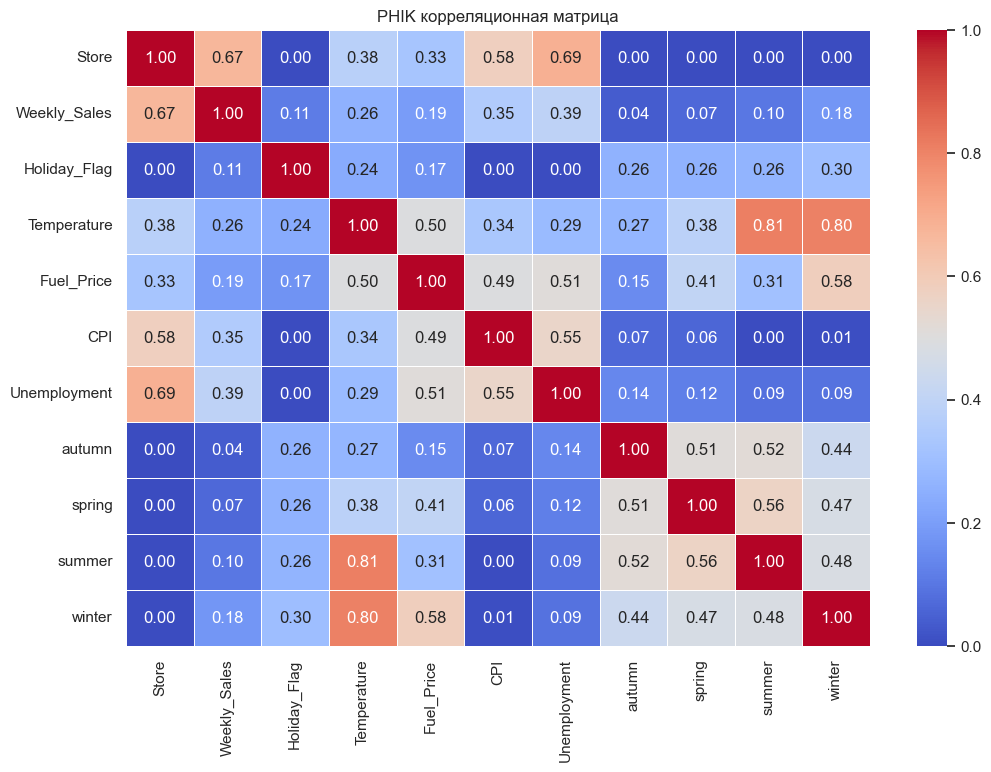

In [18]:
# Вычисляем phik-коэффициенты
phik_corr = data.phik_matrix()

# Визуализируем
plt.figure(figsize=(12, 8))
sns.heatmap(phik_corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("PHIK корреляционная матрица")
plt.show()

Видно, что сильных корреляций с целевой переменной нет. 

In [7]:
y = data['Weekly_Sales']
X = data.drop('Weekly_Sales', axis=1)

In [8]:
# 1. Разделение данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# 2. Определение пайплайна
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures()),  # Добавляем PolynomialFeatures
    ('model', GradientBoostingRegressor())
])

In [48]:

space_SGD = {
    'poly__degree': hp.choice('poly__degree', [1, 2, 3]),  # Степень полинома
    'model__loss': hp.choice('model__loss', ['squared_error', 'huber', 'epsilon_insensitive']),  # Функция потерь
    'model__penalty': hp.choice('model__penalty', ['l2', 'l1', 'elasticnet']),  # Регуляризация
    'model__alpha': hp.loguniform('model__alpha', -5, -1),  # Коэффициент регуляризации (0.00001 - 0.1)
    'model__l1_ratio': hp.uniform('model__l1_ratio', 0, 1),  # Баланс L1/L2 для ElasticNet
    'model__learning_rate': hp.choice('model__learning_rate', ['constant', 'optimal', 'invscaling', 'adaptive']),  # Вид темпа обучения
    'model__eta0': hp.loguniform('model__eta0', -4, 0),  # Начальный learning rate (0.0001 - 1.0)
    'model__max_iter': hp.choice('model__max_iter', [500, 1000, 2000]),  # Число итераций
    'model__epsilon': hp.uniform('model__epsilon', 0.01, 0.1),  # Чувствительность для Huber / epsilon-insensitive
}


In [11]:
# 3. Определение пространства гиперпараметров для Hyperopt

space = {
    'poly__degree': hp.choice('poly__degree', [1, 2, 3]),  # Степень полинома
    'model__n_estimators': hp.choice('model__n_estimators', range(50, 500)),  # Количество деревьев
    'model__learning_rate': hp.loguniform('model__learning_rate', -3, 0),  # Темп обучения (0.001 - 1.0)
    'model__max_depth': hp.choice('model__max_depth', range(2, 20)),  # Глубина деревьев
    'model__min_samples_split': hp.uniform('model__min_samples_split', 0.01, 0.5),  # Минимальное количество образцов для разделения
    'model__min_samples_leaf': hp.uniform('model__min_samples_leaf', 0.01, 0.5),  # Минимальное количество образцов в листе
    'model__subsample': hp.uniform('model__subsample', 0.5, 1.0),  # Доля выборки для обучения каждого дерева
}


In [38]:
space_neuro = {
    'poly__degree': hp.choice('poly__degree', [1, 2, 3]),  # Степень полинома
    'model__hidden_layer_sizes': hp.choice('model__hidden_layer_sizes', [
        (50,), (100,), (50, 50), (100, 50), (100, 100), (200, 100, 50)
    ]),  # Структура скрытых слоев
    'model__activation': hp.choice('model__activation', ['relu', 'tanh', 'logistic']),  # Функция активации
    'model__solver': hp.choice('model__solver', ['adam', 'sgd']),  # Оптимизатор
    'model__learning_rate_init': hp.loguniform('model__learning_rate_init', -4, -1),  # Темп обучения (0.0001 - 0.1)
    'model__alpha': hp.loguniform('model__alpha', -5, -1),  # Регуляризация L2 (0.00001 - 0.1)
    'model__batch_size': hp.choice('model__batch_size', [16, 32, 64, 128]),  # Размер мини-батча
    'model__max_iter': hp.choice('model__max_iter', [200, 500, 1000]),  # Число итераций
}

In [12]:
# 4. Функция для оптимизации параметров
def objective(params):
    pipeline.set_params(**params)
    score = -cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2').mean()
    return {'loss': score, 'status': STATUS_OK}

In [16]:
# 5. Запуск оптимизации с помощью Hyperopt

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

print("Лучшие гиперпараметры:", best)


'\ntrials = Trials()\nbest = fmin(fn=objective,\n            space=space,\n            algo=tpe.suggest,\n            max_evals=50,\n            trials=trials)\n\nprint("Лучшие гиперпараметры:", best)\n'

In [21]:
# 7. Обучение модели с лучшими гиперпараметрами
pipeline.set_params(**best)
pipeline.fit(X_train, y_train)

"'\n# 7. Обучение модели с лучшими гиперпараметрами\npipeline.set_params(**best)\npipeline.fit(X_train, y_train)\n"

In [18]:
import pickle

In [79]:
# Сохраним модель в файл
with open("model1.pickle", "wb") as file:
    pickle.dump(pipeline, file)

In [19]:
# Загрузим модель из файла
with open("model1.pickle", "rb") as file:
    deserialized_data = pickle.load(file)
pipeline = deserialized_data

In [22]:
# 8. Оценка модели на тестовой выборке
y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
R2 = r2_score(y_test, y_pred)
print(f"Среднеквадратичная ошибка на тестовой выборке: {mse}")
print(f"R2-score: {R2}")

Среднеквадратичная ошибка на тестовой выборке: 21137453244.72847
R2-score: 0.9343872303384549


In [23]:
# 8. Оценка модели на тренировочной выборке
y_pred = pipeline.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
R2 = r2_score(y_train, y_pred)
print(f"Среднеквадратичная ошибка на тренировочной выборке: {mse}")
print(f"R2-score: {R2}")

Среднеквадратичная ошибка на тренировочной выборке: 13570104591.074152
R2-score: 0.9572618309407165


Визулизируем результаты работы модели на тестовой выборке.

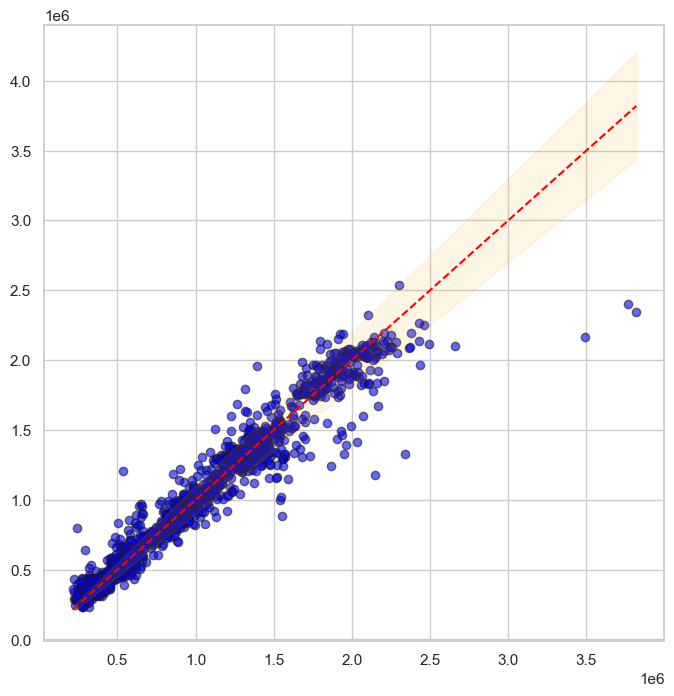

In [24]:
# Настройка стиля
sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))

# График предсказаний vs Фактические значения
plt.scatter(y_test, y_pred, alpha=0.6, edgecolor='k', color='blue', label='Предсказания')

# Линия идеальной модели (y = x)
max_value = max(np.max(y_test), np.max(y_pred))
min_value = min(np.min(y_test), np.min(y_pred))
plt.plot([min_value, max_value], [min_value, max_value], color='red', linestyle='--', label='Идеальная модель (y = x)')

# Подсветка области вокруг линии y = x (±10%)
plt.fill_between([min_value, max_value], 
                 [min_value * 0.9, max_value * 0.9], 
                 [min_value * 1.1, max_value * 1.1], 
                 color='orange', alpha=0.1, label='±10% ошибки')

In [25]:
# Выполним кроссвалидацию
np.mean(cross_val_score(pipeline, X,y,cv = 5))

-0.3917545147951423

Для обучения..
RandomForestRegressor:
Среднеквадратичная ошибка на тестовой выборке: 230922476877.98767
R2-score: 0.28319352811117227
GradientBoostingRegressor:
Среднеквадратичная ошибка на тестовой выборке: 21137453244.72847
R2-score: 0.9343872303384549